<a href="https://colab.research.google.com/github/evelimes/HackerRank/blob/master/ML4FG_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Train the classifier for each disease independently
2. We store the weights fo the embedding layer
3. Create a new classifier - does not accept custtom embedding layer

4. Pass input through cusotm embedding -  depending on dimensions
5. Get uniform size embedding for all data
6. Use the embeddings as input to train a multi-class classification model.


## Link to data dir

In [115]:
from google.colab import drive
drive.mount("/content/drive/")
datadir="/content/drive/MyDrive/ML4fungen final project/"
!ls "$datadir" | tail

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
chd-seq.csv
gene-risk-labels.csv
ML4FG Final Report.gdoc
ML4FG_project.ipynb
ML4fungen final report TO DO List.gdoc
rna-seq_counts_SCH.csv
sch_auc.png
sch_gene_preds.csv
SCHgenes-risk.csv
sch-seq.csv


## Imports

In [116]:

import numpy as np
import pandas as pd
from functools import reduce

from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import interp 
from itertools import cycle

import matplotlib.pyplot as plt

In [117]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold

# Model definition

In [118]:
class CustomEmbedding(nn.Module):
    def __init__(self, inputs, hidden):
        super().__init__()
        self.l1 = nn.Linear(inputs, hidden)
        self.l2 = nn.Linear(hidden, hidden)
        self.bn = nn.BatchNorm1d(hidden)
        self.relu = nn.ReLU()
        self.dropout  = nn.Dropout(0.5)

    def forward(self, x):
        x = self.l1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.l2(x)
        return x

class SimpleNN(nn.Module):
    def __init__(self, embedding_layer, hidden, outputs):
        super().__init__()
        self.emb =  embedding_layer
        self.bn1 = nn.BatchNorm1d(hidden)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.l1 = nn.Linear(hidden, hidden)
        self.l2 = nn.Linear(hidden, outputs)
        self.relu = nn.ReLU()
        self.dropout  = nn.Dropout(0.5)

    def forward(self, x):
        x = self.emb(x)
        # x = self.dropout(x)
        # x = self.relu(x)
        # x = self.bn1(x)
        # x = self.l1(x)
        x = self.dropout(x)
        x = self.relu(x)
        # x = torch.tanh(x)
        x = self.bn2(x)
        x = self.l2(x)
        return x

# train funciton

In [119]:
def train_one_epoch(model, inputs, labels, loss_func, optimizer, device, acc_func=None):
   
    optimizer.zero_grad()
    # inputs = inputs.cuda()
    # labels = labels.cuda()
    outputs = model(inputs)

    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    if acc_func:
        acc = acc_func(outputs,labels)
        accuracy =  acc.data.cpu()
    

    epoch_loss = loss.data.cpu()

    if acc_func:
        return epoch_loss, accuracy
    
    return epoch_loss

# eval function

In [120]:
def calc_accuracy(outputs, labels):
    return torch.mean((torch.argmax(outputs, dim=1) == labels).float())

In [122]:
@torch.no_grad()
def evaluate(model, inputs, labels, loss_func, device, acc_func=None, pr=True):
    model.eval()
    tp=0
    fp=0
    tot_p=0
    # inputs = inputs.cuda()
    # labels = labels.cuda()
    outputs = model(inputs)

    loss = loss_func(outputs, labels)
    epoch_loss = loss.data.cpu()
    if acc_func:
        accuracy = acc_func(outputs,labels)
    
    if pr:
        tp+= torch.sum(torch.logical_and(torch.argmax(outputs, dim=1), labels))
        fp+= torch.sum(torch.logical_and(torch.argmax(outputs, dim=1), torch.logical_not(labels)))
        tot_p+=torch.sum(labels)

    if pr:
        recall = tp/tot_p
        precision = tp/(tp+fp)
        f1 = 2*precision*recall/(precision+recall)
        # print("Recall = ", recall, tp, fp, tot_p)
        # print("Precision = ", precision)
        # print("F1 score = ", f1)

    if acc_func:
        return epoch_loss, accuracy, precision, recall, f1
    
    return epoch_loss

## Get data

In [123]:
from pathlib import Path
import numpy as np
import pandas as pd
from functools import reduce

path_to_assigment_dir = Path("/content/drive/My Drive/ML4fungen final project")
autdata = pd.read_csv(path_to_assigment_dir /"aut-seq.csv", index_col=0)
autdata = autdata.transpose()

chddata = pd.read_csv(path_to_assigment_dir /"chd-seq.csv", index_col=0)
chddata = chddata.transpose()

schdata = pd.read_csv(path_to_assigment_dir /"sch-seq.csv", index_col=0)
schdata = schdata.transpose()
schdata.iloc[:6,:8]

Gene,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS
CA1_CTL_0815,-0.305129,-0.322929,1.156678,-0.262462,-0.319919,-0.312851,-0.322929,-0.239034
CA1_CTL_0817,-0.288902,-0.301473,0.241984,-0.277341,-0.300013,-0.294851,-0.301922,-0.251190
CA1_CTL_0819,-0.318663,-0.342822,0.865400,-0.294746,-0.339908,-0.332867,-0.342822,-0.252375
CA1_CTL_0823,-0.305430,-0.324059,0.670341,-0.277794,-0.323138,-0.319351,-0.324059,-0.263361
CA1_CTL_0827,-0.317849,-0.337633,0.533127,-0.303401,-0.336461,-0.331906,-0.337372,-0.258236
CA1_CTL_0828,-0.309713,-0.340803,0.709763,-0.289034,-0.339536,-0.330533,-0.341084,-0.246831


In [124]:
risk = pd.read_csv(path_to_assigment_dir / "gene-risk-labels.csv",  index_col = 0)
risk.iloc[:6,:8]

,aut,chd,sch
AASDH,0,0,1
ABCA1,0,0,1
ABCA2,0,0,1
ABCB11,0,0,1
ABCC9,1,0,0
ABCD3,1,0,0


*Generate common genes for every disease*

In [125]:
#aut filter
common_genes = [g for g in risk.index]
common_genes = list(set(common_genes).intersection(autdata.columns.tolist() ))
common_genes = sorted(common_genes) # required for reproducibility, set order is undefined
aut_exp = autdata[common_genes]
aut_exp.shape

(95, 787)

In [126]:
aut_risk = risk.loc[common_genes, :]
aut_risk = aut_risk["aut"]
aut_risk.head()

AASDH    0
ABCA1    0
ABCA2    0
ABCC9    1
ABCD3    1
Name: aut, dtype: int64

In [127]:
#chd filter 
common_genes2 = [g for g in risk.index]
common_genes2 = list(set(common_genes2).intersection(chddata.columns.tolist() ))
common_genes2 = sorted(common_genes2) # required for reproducibility, set order is undefined
chd_exp = chddata[common_genes2]
chd_exp.shape

(11, 102)

In [128]:
chd_risk = risk.loc[common_genes2,:]
chd_risk = chd_risk["chd"]
chd_risk.shape

(102,)

In [129]:
#sch filter
common_genes3 = [g for g in risk.index]
common_genes3 = list(set(common_genes3).intersection(schdata.columns.tolist()))
common_genes3 = sorted(common_genes3) # required for reproducibility, set order is undefined
sch_exp = schdata[common_genes3]
sch_exp.shape

(78, 882)

In [130]:
sch_risk = risk.loc[common_genes3,:]
sch_risk = sch_risk["sch"]
sch_risk.shape

(882,)

# Autism

In [142]:
aut_exp_n = np.array(aut_exp).T
aut_risk_n = np.array(aut_risk)
np.mean(aut_risk_n)

,AASDH,ABCA1,ABCA2,ABCC9,ABCD3,ABR,ACAN,ACTB,ACTR3,ACVR2B,ADAM32,ADAMTS10,ADAMTS18,ADAMTS20,ADAMTS6,ADCY1,ADD1,ADD2,ADNP,ADRA1A,ADSL,AGAP3,AIG1,AIRE,AK4,AKAP13,ALG9,ALS2,AMPD2,AMPH,ANK2,ANKDD1A,ANKRD11,ANKRD50,ANKS1B,ANKS6,AP1B1,AP2B1,AP5Z1,ARHGAP25,...,WDR19,WDR34,WDR35,WDR48,WDR60,WDR66,WIPF3,WNK3,WWC2,WWOX,XKR6,XPC,XRRA1,ZACN,ZBTB14,ZBTB39,ZC3H13,ZEB2,ZFHX2,ZFP64,ZFPM2,ZIC3,ZNF165,ZNF197,ZNF213,ZNF236,ZNF407,ZNF423,ZNF516,ZNF528,ZNF623,ZNF644,ZNF721,ZNF749,ZNF804A,ZNF831,ZNFX1,ZSCAN2,ZSWIM7,ZW10
hRgl2a_7,0.301465,-0.329083,-0.644357,0.301465,-0.013809,0.301465,-0.644357,4.715301,1.877835,2.508383,-0.644357,-0.644357,-0.644357,-0.644357,0.932013,0.301465,0.932013,0.301465,2.823657,-0.644357,1.562561,0.301465,0.932013,-0.644357,-0.329083,0.932013,-0.329083,0.301465,-0.013809,-0.013809,0.932013,-0.644357,2.193109,0.616739,-0.013809,-0.329083,-0.329083,3.454205,-0.644357,-0.644357,...,-0.644357,-0.329083,2.193109,1.877835,0.301465,-0.013809,-0.329083,0.932013,0.616739,-0.329083,-0.644357,1.247287,-0.013809,-0.329083,-0.644357,-0.644357,2.193109,1.247287,-0.644357,-0.329083,-0.644357,-0.644357,-0.644357,-0.013809,-0.644357,-0.329083,-0.644357,-0.329083,0.616739,0.301465,-0.329083,1.247287,0.932013,-0.644357,-0.644357,-0.644357,-0.013809,-0.644357,-0.644357,-0.013809
hProgBP_7,0.580237,-0.190516,0.580237,-0.575892,0.580237,0.580237,-0.575892,4.819379,0.580237,2.892496,-0.575892,-0.575892,-0.575892,-0.575892,0.965614,-0.190516,0.580237,-0.190516,0.194861,-0.575892,1.736367,0.580237,0.580237,-0.575892,0.965614,0.965614,0.194861,-0.575892,-0.575892,-0.190516,1.736367,-0.190516,2.121743,-0.190516,-0.575892,-0.190516,-0.190516,2.507120,0.580237,-0.575892,...,0.965614,0.580237,0.965614,2.121743,-0.190516,-0.190516,-0.575892,0.194861,-0.575892,0.194861,-0.575892,0.194861,-0.575892,-0.575892,-0.575892,-0.190516,1.350990,1.350990,-0.575892,-0.190516,-0.575892,-0.575892,-0.575892,-0.190516,-0.575892,-0.190516,-0.575892,-0.190516,-0.575892,0.580237,-0.575892,1.736367,0.965614,0.194861,-0.575892,-0.575892,-0.575892,-0.575892,-0.190516,0.580237
hOMTN_7,0.991196,-0.312976,-0.312976,-0.639018,0.665153,1.317239,-0.639018,4.903711,0.991196,1.969325,-0.639018,-0.639018,0.665153,-0.312976,-0.639018,1.969325,0.991196,1.317239,0.665153,-0.639018,0.665153,1.969325,-0.312976,-0.639018,0.339110,0.665153,0.665153,0.013068,0.339110,0.665153,2.947453,-0.312976,1.969325,0.339110,0.665153,-0.639018,-0.312976,3.273496,-0.639018,-0.639018,...,-0.639018,-0.312976,-0.312976,1.317239,-0.312976,-0.639018,-0.639018,1.643282,-0.639018,-0.639018,-0.639018,0.665153,-0.639018,-0.639018,0.339110,-0.639018,3.273496,0.339110,0.013067,0.013068,-0.312976,-0.639018,-0.639018,1.317239,-0.639018,-0.312976,-0.312976,0.013067,0.339110,0.339110,-0.639018,1.643282,0.339110,-0.639018,1.643282,-0.639018,-0.639018,-0.312976,1.643282,-0.639018
hRgl2a_9,2.292747,0.170520,-0.678371,-0.678371,1.868302,0.170520,-0.678371,4.839421,1.443857,2.292747,-0.678371,-0.253926,-0.678371,-0.678371,-0.253926,-0.678371,1.868302,-0.253926,1.443857,-0.678371,1.019411,1.019411,-0.253926,-0.678371,0.594965,1.019411,-0.253926,0.594965,0.594965,-0.253926,1.443857,-0.253926,2.717193,1.443857,0.170520,-0.678371,-0.253926,3.141639,0.170520,-0.678371,...,1.019411,-0.678371,1.019411,0.594965,0.170520,0.170520,-0.678371,1.868302,0.170520,0.170520,0.594965,0.594965,0.170520,-0.678371,-0.678371,-0.253926,1.019411,1.443857,-0.253926,-0.253926,-0.253926,-0.678371,-0.678371,-0.678371,-0.253926,0.170520,-0.678371,0.170520,0.594965,0.170520,-0.253926,3.141639,0.594965,-0.678371,0.170520,-0.678371,-0.253926,0.170520,-0.253926,-0.253926
hNProg_9,1.255239,1.255239,-0.181248,-0.660077,1.734068,1.255239,-0.660077,5.085872,0.776410,2.691726,-0.660077,-0.181248,-0.660077,-0.660077,0.297581,-0.181248,2.212897,0.297581,4.128213,-0.660077,-0.660077,1.255239,-0.660077,-0.660077,0.297581,2.212897,-0.660077,-0.181248,-0.660077,-0.660077,3.649385,-0.660077,1.734068,0.776410,-0.181248,-0.660077,0.297581,2.212897,0.297581,-0.660077,...

In [132]:
inputs_train, inputs_val, labels_train, labels_val = model_selection.train_test_split(aut_exp_n, aut_risk_n, test_size=0.2,
                                                        random_state=0)

In [133]:
inputs_train = torch.tensor(inputs_train, dtype=torch.float32, requires_grad=True)
inputs_val = torch.tensor(inputs_val, dtype=torch.float32, requires_grad=True)
labels_train = torch.tensor(labels_train, dtype=torch.long)
labels_val = torch.tensor(labels_val, dtype=torch.long)
[inputs_train.shape,inputs_train.dtype,inputs_train.requires_grad, 
 inputs_val.shape,inputs_val.dtype, labels_train.shape,labels_train.dtype, 
 labels_val.shape, labels_val.dtype]

[torch.Size([629, 95]),
 torch.float32,
 True,
 torch.Size([158, 95]),
 torch.float32,
 torch.Size([629]),
 torch.int64,
 torch.Size([158]),
 torch.int64]

In [134]:
inputs_train.shape,inputs_train.dtype,inputs_train.requires_grad, inputs_val.shape,inputs_val.dtype, labels_train.shape,labels_train.dtype, labels_val.shape, labels_val.dtype

(torch.Size([629, 95]),
 torch.float32,
 True,
 torch.Size([158, 95]),
 torch.float32,
 torch.Size([629]),
 torch.int64,
 torch.Size([158]),
 torch.int64)

## Init model

In [135]:
aut_embed = CustomEmbedding(95, 60)
aut_cla = SimpleNN(aut_embed, 60, 2)
loss_func = nn.CrossEntropyLoss(torch.tensor([0.7,  0.3]))
optimizer = torch.optim.Adam(aut_cla.parameters())
model = aut_cla
device = torch.device("cpu")

In [136]:
from copy import  copy

## train for autism

In [137]:
max_val_accs = []
aut_embed_state_dicts = []
for i in range(20):
    aut_embed = CustomEmbedding(95, 60)
    aut_cla = SimpleNN(aut_embed, 60, 2)
    loss_func = nn.CrossEntropyLoss(torch.tensor([0.3,  0.7]))
    optimizer = torch.optim.Adam(aut_cla.parameters())
    model = aut_cla
    device = torch.device("cpu")

    num_epochs = 100000
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    print_freq = 1000
    patience = 2000
    patience_2 = patience
    max_val_acc = 0
    aut_embed_state_dict = None
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        if patience==0:
            print("Training complete")
            break
        model.train()
        train_loss, train_acc = train_one_epoch(model, inputs_train, labels_train, loss_func, optimizer, device, acc_func=calc_accuracy)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # evaluate on the test dataset
        model.eval()
        val_loss, accuracy, precision, recall, val_acc = evaluate(model, inputs_val, labels_val, loss_func, device, acc_func=calc_accuracy, pr=True)
        patience -= 1
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            patience =  patience_2
            aut_embed_state_dict = aut_embed.state_dict().copy()
            print(f"Epoch {epoch} \t Max val Acc = {val_acc}, {accuracy}")
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if epoch%print_freq==0:    
            print(f"Epoch =  {epoch} \t Train loss = {train_loss:.5f} \t  Train Acc = {train_acc:.5f} \t",
            f"Val loss = {val_loss:.5f} \t Acc = {precision:.5f}{recall:.5f}{val_acc:.5f} \t Patience = {patience}")
    max_val_accs.append(max_val_acc)
    aut_embed_state_dicts.append(aut_embed_state_dict)

print("Max val losses________________")
print(max_val_accs)

Epoch 0 	 Max val Acc = 0.42384102940559387, 0.44936707615852356
Epoch =  0 	 Train loss = 0.75125 	  Train Acc = 0.55803 	 Val loss = 0.69056 	 Acc = 0.329900.592590.42384 	 Patience = 2000
Epoch 2 	 Max val Acc = 0.43356648087501526, 0.4873417615890503
Epoch 3 	 Max val Acc = 0.43661975860595703, 0.49367088079452515
Epoch 4 	 Max val Acc = 0.4740740656852722, 0.550632894039154
Epoch 5 	 Max val Acc = 0.5116279125213623, 0.6012658476829529
Epoch 6 	 Max val Acc = 0.5538461804389954, 0.6329113841056824
Epoch 7 	 Max val Acc = 0.5625, 0.6455696225166321
Epoch 11 	 Max val Acc = 0.585365891456604, 0.6772152185440063
Epoch 12 	 Max val Acc = 0.5932203531265259, 0.6962025165557861
Epoch 37 	 Max val Acc = 0.5982906222343445, 0.702531635761261
Epoch =  1000 	 Train loss = 0.08269 	  Train Acc = 0.96025 	 Val loss = 3.05865 	 Acc = 0.482760.259260.33735 	 Patience = 1037
Epoch =  2000 	 Train loss = 0.02986 	  Train Acc = 0.98569 	 Val loss = 4.17522 	 Acc = 0.464290.240740.31707 	 Patience 

In [138]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
pre_df = pd.DataFrame(index = autdata.index)
oddsratio_df = pd.DataFrame(index = np.arange(0.0,1.05,0.05))
fi_df = pd.DataFrame()
combine = aut_exp_n
label = pd.DataFrame(aut_risk_n, columns=["labels"])
max_val_accs = []
aut_embed_state_dicts = []
for train, test in cv.split(aut_exp_n, label):
    inputs_train = torch.tensor(aut_exp_n[train], dtype=torch.float32, requires_grad=True)
    inputs_val = torch.tensor(aut_exp_n[test], dtype=torch.float32, requires_grad=True)
    labels_train = torch.tensor(aut_risk_n[train], dtype=torch.long)
    labels_val = torch.tensor(aut_risk_n[test], dtype=torch.long)

    for i in range(5):
        aut_embed = CustomEmbedding(95, 60)
        aut_cla = SimpleNN(aut_embed, 60, 2)
        loss_func = nn.CrossEntropyLoss(torch.tensor([0.3,  0.7]))
        optimizer = torch.optim.Adam(aut_cla.parameters())
        model = aut_cla
        device = torch.device("cpu")

        num_epochs = 100000
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        print_freq = 1000
        patience = 2000
        patience_2 = patience
        max_val_acc = 0
        aut_embed_state_dict = None
        for epoch in range(num_epochs):
            # train for one epoch, printing every 10 iterations
            if patience==0:
                print("Training complete")
                break
            model.train()
            train_loss, train_acc = train_one_epoch(model, inputs_train, labels_train, loss_func, optimizer, device, acc_func=calc_accuracy)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            # evaluate on the test dataset
            model.eval()
            val_loss, accuracy, precision, recall, val_acc = evaluate(model, inputs_val, labels_val, loss_func, device, acc_func=calc_accuracy, pr=True)
            patience -= 1
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                patience =  patience_2
                aut_embed_state_dict = aut_embed.state_dict().copy()
                print(f"Epoch {epoch} \t Max val Acc = {val_acc}, {accuracy}")
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            if epoch%print_freq==0:    
                print(f"Epoch =  {epoch} \t Train loss = {train_loss:.5f} \t  Train Acc = {train_acc:.5f} \t",
                f"Val loss = {val_loss:.5f} \t Acc = {precision:.5f}{recall:.5f}{val_acc:.5f} \t Patience = {patience}")
        max_val_accs.append(max_val_acc)
        aut_embed_state_dicts.append(aut_embed_state_dict)

print("Max val losses________________")
print(max_val_accs)

Epoch 0 	 Max val Acc = 0.4651162624359131, 0.5632911324501038
Epoch =  0 	 Train loss = 0.78558 	  Train Acc = 0.48331 	 Val loss = 0.68657 	 Acc = 0.370370.625000.46512 	 Patience = 2000
Epoch 4 	 Max val Acc = 0.5178571343421936, 0.6582278609275818
Epoch 5 	 Max val Acc = 0.5471698045730591, 0.6962025165557861
Epoch 6 	 Max val Acc = 0.557692289352417, 0.7088607549667358
Epoch 160 	 Max val Acc = 0.5714285373687744, 0.7721518874168396
Epoch 162 	 Max val Acc = 0.5783132910728455, 0.7784810066223145
Epoch 164 	 Max val Acc = 0.5952380895614624, 0.7848101258277893
Epoch =  1000 	 Train loss = 0.08693 	  Train Acc = 0.97138 	 Val loss = 2.25698 	 Acc = 0.444440.250000.32000 	 Patience = 1164
Epoch =  2000 	 Train loss = 0.05448 	  Train Acc = 0.98410 	 Val loss = 2.96527 	 Acc = 0.482760.291670.36364 	 Patience = 164
Training complete
Epoch 0 	 Max val Acc = 0.4660193920135498, 0.3037974536418915
Epoch =  0 	 Train loss = 0.75394 	  Train Acc = 0.44992 	 Val loss = 0.69110 	 Acc = 0.30

In [143]:
len(aut_embed_state_dicts)

25

In [144]:
aut_embed2 = CustomEmbedding(95, 60)
aut_embed2.load_state_dict(aut_embed_state_dicts[np.argmax(max_val_accs)])
aut_cla = SimpleNN(aut_embed2,  60,2)
aut_cla.eval()
evaluate(aut_cla, inputs_train, labels_train, loss_func, device, calc_accuracy, pr=True)

(tensor(0.7486),
 tensor(0.3143),
 tensor(0.3082),
 tensor(0.9948),
 tensor(0.4706))

In [145]:
aut_cla.eval()
evaluate(aut_cla, inputs_train, labels_train, loss_func, device, calc_accuracy, pr=True)

(tensor(0.7486),
 tensor(0.3143),
 tensor(0.3082),
 tensor(0.9948),
 tensor(0.4706))

In [146]:
np.mean(max_val_accs) # 2 layer- (input hidden hidden) 30 - dropout

0.5738622

In [147]:
np.mean(max_val_accs) # 2 layer- (input hidden hidden) 60 - dropout

0.5738622

In [148]:
np.mean(max_val_accs) # 2 layer- (input hidden hidden) 100 - dropout

0.5738622

In [149]:
np.mean(max_val_accs) # 2 layer- (input input hidden) 30 - dropout

0.5738622

In [150]:
np.mean(max_val_accs) # 2 layer- (input input hidden) 60 - dropout

0.5738622

In [151]:
np.mean(max_val_accs) # 2 layer- (input input hidden) 100 - dropout

0.5738622

In [152]:
np.mean(max_val_accs) # - hidden 30 - dropout

0.5738622

In [153]:
np.mean(max_val_accs) # - hidden 100 - dropout

0.5738622

In [154]:
np.mean(max_val_accs) # - hidden 60 - dropout

0.5738622

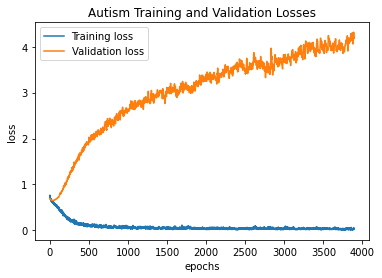

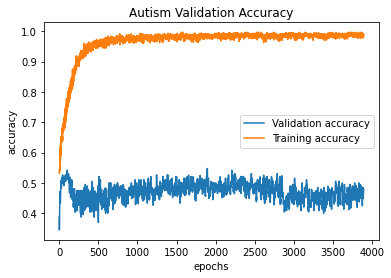

In [155]:
plt.plot(train_losses,label="Training loss")
plt.plot(val_losses,label="Validation loss")
plt.title('Autism Training and Validation Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(val_accuracies, label="Validation accuracy")
plt.plot(train_accuracies, label="Training accuracy")
plt.title('Autism Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Schizo

In [156]:
sch_exp_n = np.array(sch_exp).T
sch_risk_n = np.array(sch_risk)
np.mean(sch_risk_n), len(sch_risk_n)

(0.6428571428571429, 882)

In [157]:
inputs_train, inputs_val, labels_train, labels_val = model_selection.train_test_split(sch_exp_n, sch_risk_n, test_size=0.25,
                                                        random_state=0)

In [ ]:
inputs_train = torch.tensor(inputs_train, dtype=torch.float32, requires_grad=True)
inputs_val = torch.tensor(inputs_val, dtype=torch.float32, requires_grad=True)
labels_train = torch.tensor(labels_train, dtype=torch.long)
labels_val = torch.tensor(labels_val, dtype=torch.long)
[inputs_train.shape,inputs_train.dtype,inputs_train.requires_grad, 
 inputs_val.shape,inputs_val.dtype, labels_train.shape,labels_train.dtype, 
 labels_val.shape, labels_val.dtype]

In [ ]:
inputs_train.shape,inputs_train.dtype,inputs_train.requires_grad, inputs_val.shape,inputs_val.dtype, labels_train.shape,labels_train.dtype, labels_val.shape, labels_val.dtype

## Init model

In [85]:
sch_embed = CustomEmbedding(78, 100)
sch_cla = SimpleNN(sch_embed, 100, 2)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sch_cla.parameters())
model = sch_cla
device = torch.device("cpu")

## train for schizo

In [98]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
pre_df = pd.DataFrame(index = data.index)
oddsratio_df = pd.DataFrame(index = np.arange(0.0,1.05,0.05))
fi_df = pd.DataFrame()
combine = sch_exp_n
label = pd.DataFrame(sch_risk_n, columns=["labels"])
max_val_accs = []
sch_embed_state_dicts = []
for train, test in cv.split(sch_exp_n, label):
    inputs_train = torch.tensor(sch_exp_n[train], dtype=torch.float32, requires_grad=True)
    inputs_val = torch.tensor(sch_exp_n[test], dtype=torch.float32, requires_grad=True)
    labels_train = torch.tensor(sch_risk_n[train], dtype=torch.long)
    labels_val = torch.tensor(sch_risk_n[test], dtype=torch.long)

    for i in range(5):
        sch_embed = CustomEmbedding(78, 60)
        sch_cla = SimpleNN(sch_embed, 60, 2)
        loss_func = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(sch_cla.parameters())
        model = sch_cla
        device = torch.device("cpu")

        num_epochs = 100000
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        print_freq = 1000
        patience = 2000
        patience_2 = patience
        max_val_acc = 0
        sch_embed_state_dict = None
        for epoch in range(num_epochs):
            # train for one epoch, printing every 10 iterations
            if patience==0:
                print("Training complete")
                break
            model.train()
            train_loss, train_acc = train_one_epoch(model, inputs_train, labels_train, loss_func, optimizer, device, acc_func=calc_accuracy)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            # evaluate on the test dataset
            model.eval()
            val_loss, accuracy, precision, recall, val_acc = evaluate(model, inputs_val, labels_val, loss_func, device, acc_func=calc_accuracy, pr=True)
            patience -= 1
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                patience =  patience_2
                sch_embed_state_dict = sch_embed.state_dict().copy()
                print(f"Epoch {epoch} \t Max val Acc = {val_acc}, {accuracy}")
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            if epoch%print_freq==0:    
                print(f"Epoch =  {epoch} \t Train loss = {train_loss:.5f} \t  Train Acc = {train_acc:.5f} \t",
                f"Val loss = {val_loss:.5f} \t Acc = {precision:.5f}{recall:.5f}{val_acc:.5f} \t Patience = {patience}")
        max_val_accs.append(max_val_acc)
        sch_embed_state_dicts.append(sch_embed_state_dict)

print("Max val losses________________")
print(max_val_accs)

Epoch =  0 	 Train loss = 0.76086 	  Train Acc = 0.51915 	 Val loss = 0.70242 	 Acc = nan0.00000nan 	 Patience = 1999
Epoch 1 	 Max val Acc = 0.5257143378257751, 0.5310734510421753
Epoch 2 	 Max val Acc = 0.663551390171051, 0.5932203531265259
Epoch 3 	 Max val Acc = 0.6929824352264404, 0.604519784450531
Epoch 4 	 Max val Acc = 0.7136929035186768, 0.6101694703102112
Epoch 5 	 Max val Acc = 0.7177419066429138, 0.604519784450531
Epoch 7 	 Max val Acc = 0.7364341020584106, 0.6158192157745361
Epoch 8 	 Max val Acc = 0.7573529481887817, 0.6271186470985413
Epoch 9 	 Max val Acc = 0.7591240406036377, 0.6271186470985413
Epoch 10 	 Max val Acc = 0.7681159377098083, 0.6384180784225464
Epoch 11 	 Max val Acc = 0.7857142686843872, 0.6610169410705566
Epoch 12 	 Max val Acc = 0.7885305285453796, 0.6666666865348816
Epoch 13 	 Max val Acc = 0.7956989407539368, 0.6779661178588867
Epoch 327 	 Max val Acc = 0.796875, 0.7062146663665771
Epoch 329 	 Max val Acc = 0.801556408405304, 0.7118644118309021
Epoch 

In [ ]:
sch_embed2 = CustomEmbedding(78, 60)
sch_embed2.load_state_dict(sch_embed_state_dicts[np.argmax(max_val_accs)])
sch_cla = SimpleNN(sch_embed2,  60,2)
sch_cla.eval()
evaluate(sch_cla, inputs_train, labels_train, loss_func, device, calc_accuracy, pr=True)

In [88]:
np.mean(max_val_accs) # 2 layer- (input hidden hidden) 60 - dropout

0.54567784

In [89]:
np.mean(max_val_accs) # 2 layer- (input hidden hidden) 100 - dropout

0.54567784

In [90]:
np.mean(max_val_accs) # 2 layer- (input input hidden) 30 - dropout

0.54567784

In [91]:
np.mean(max_val_accs) # 2 layer- (input input hidden) 60 - dropout

0.54567784

In [92]:
np.mean(max_val_accs) # 2 layer- (input input hidden) 100 - dropout

0.54567784

In [93]:
np.mean(max_val_accs) # - hidden 30 - dropout

0.54567784

In [94]:
np.mean(max_val_accs) # - hidden 100 - dropout

0.54567784

In [95]:
np.mean(max_val_accs) # - hidden 60 - dropout

0.54567784

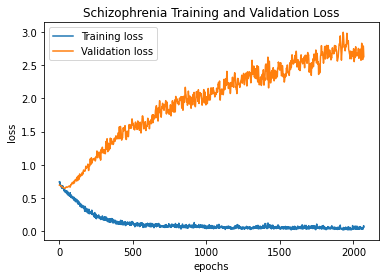

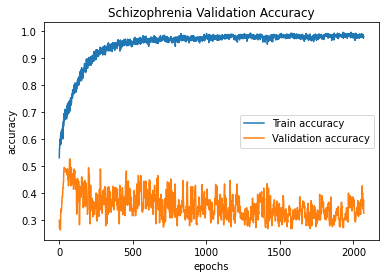

In [97]:
plt.plot(train_losses,label="Training loss")
plt.plot(val_losses,label="Validation loss")
plt.title('Schizophrenia Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(val_accuracies, label="Validation accuracy")
plt.title('Schizophrenia Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# CHD

In [158]:
chd_exp_n = np.array(chd_exp.iloc[:-1,:]).T.astype(np.float32)
chd_risk_n = np.array(chd_risk)
np.mean(chd_risk_n), len(chd_risk_n)

(0.09803921568627451, 102)

In [159]:
inputs_train, inputs_val, labels_train, labels_val = model_selection.train_test_split(chd_exp_n, chd_risk_n, test_size=0.3,
                                                                                      stratify=chd_risk_n, random_state=0)

In [160]:
len(labels_train)

71

In [161]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
inputs_train_res, labels_train_res = oversample.fit_resample(inputs_train, labels_train)
np.mean(labels_train_res)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.5

In [162]:
inputs_train = torch.tensor(inputs_train_res, dtype=torch.float32, requires_grad=True)
inputs_val = torch.tensor(inputs_val, dtype=torch.float32, requires_grad=True)
labels_train = torch.tensor(labels_train_res, dtype=torch.long)
labels_val = torch.tensor(labels_val, dtype=torch.long)
[inputs_train.shape,inputs_train.dtype,inputs_train.requires_grad, 
 inputs_val.shape,inputs_val.dtype, labels_train.shape,labels_train.dtype, 
 labels_val.shape, labels_val.dtype]

[torch.Size([128, 10]),
 torch.float32,
 True,
 torch.Size([31, 10]),
 torch.float32,
 torch.Size([128]),
 torch.int64,
 torch.Size([31]),
 torch.int64]

In [163]:
inputs_train.shape,inputs_train.dtype,inputs_train.requires_grad, inputs_val.shape,inputs_val.dtype, labels_train.shape,labels_train.dtype, labels_val.shape, labels_val.dtype

(torch.Size([128, 10]),
 torch.float32,
 True,
 torch.Size([31, 10]),
 torch.float32,
 torch.Size([128]),
 torch.int64,
 torch.Size([31]),
 torch.int64)

## Init model

In [166]:
chd_embed = CustomEmbedding(10, 100)
chd_cla = SimpleNN(chd_embed, 100, 2)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(chd_cla.parameters())
model = chd_cla
device = torch.device("cpu")

## train for CHD

In [168]:
max_val_accs = []
# for hidden_size in [30,60,100]:
for i in range(10):
    chd_embed = CustomEmbedding(10, 60)
    chd_cla = SimpleNN(chd_embed, 60, 2)
    w1 = 0.4
    loss_func = nn.CrossEntropyLoss(torch.tensor([1-w1, w1]))
    optimizer = torch.optim.Adam(chd_cla.parameters(), lr =0.00001)
    model = chd_cla
    device = torch.device("cpu")

    num_epochs = 100
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    print_freq = 1000
    patience = 5000
    patience_2 = patience
    max_val_acc = 0
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        if patience==0:
            # print("Training complete")
            break
        model.train()
        train_loss, train_acc = train_one_epoch(model, inputs_train, labels_train, loss_func, optimizer, device, acc_func=calc_accuracy)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # evaluate on the test dataset
              model.eval()
            val_loss, accuracy, precision, recall, val_acc = evaluate(model, inputs_val, labels_val, loss_func, device, acc_func=calc_accuracy, pr=True)
            patience -= 1
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                patience =  patience_2
                sch_embed_state_dict = sch_embed.state_dict().copy()
                print(f"Epoch {epoch} \t Max val Acc = {val_acc}, {accuracy}")
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)





        model.eval()
        val_loss, val_acc = evaluate(model, inputs_val, labels_val, loss_func, device, acc_func=calc_accuracy, pr=True)
        patience -= 1
        precision, recall, f1 = val_acc
        val_acc = f1

        if precision > recall:
          w1+=0.001
          loss_func = nn.CrossEntropyLoss(torch.tensor([1-w1, w1 ]))
        else:
          w1 = min(1, w1-0.0001)
          loss_func = nn.CrossEntropyLoss(torch.tensor([1-w1, w1]))


        if val_acc > max_val_acc:
            max_val_acc = val_acc
            patience =  patience_2
            print(f"Epoch {epoch} \t Max val Acc = {val_acc}")
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # if epoch%print_freq==0:    
        # print(f"Epoch =  {epoch} \t Train loss = {train_loss:.5f} \t  Train Acc = {train_acc:.5f} \t",
        print(f"Val loss = {val_loss:.5f} \t Acc = {precision:.5f},{recall:.5f},{val_acc:.5f},{w1} \t Patience = {patience}")

    max_val_accs.append(max_val_acc)
print("Max val losses___________________________")
print(hidden_size, max_val_accs,"\n", np.array(max_val_accs).mean())

ValueError: ignored

In [ ]:
np.mean(max_val_accs) # 2 layer- (input hidden hidden) 30 - dropout

In [ ]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
pre_df = pd.DataFrame(index = chddata.index)
oddsratio_df = pd.DataFrame(index = np.arange(0.0,1.05,0.05))
fi_df = pd.DataFrame()
combine = chd_exp_n
label = pd.DataFrame(chd_risk_n, columns=["labels"])
max_val_accs = []
chd_embed_state_dicts = []
for train, test in cv.split(chd_exp_n, label):
    from imblearn.over_sampling import RandomOverSampler
    oversample = RandomOverSampler(sampling_strategy='minority')
    # fit and apply the transform
    inputs_train_res, labels_train_res = oversample.fit_resample(chd_exp_n[train], chd_risk_n[train])
    inputs_test_res, labels_test_res = oversample.fit_resample(chd_exp_n[test], chd_risk_n[test])
    
    inputs_train = torch.tensor(inputs_train_res, dtype=torch.float32, requires_grad=True)
    inputs_val = torch.tensor(inputs_test_res, dtype=torch.float32, requires_grad=True)
    labels_train = torch.tensor(labels_train_res, dtype=torch.long)
    labels_val = torch.tensor(labels_test_res, dtype=torch.long)

    for i in range(5):
        chd_embed = CustomEmbedding(10, 60)
        chd_cla = SimpleNN(chd_embed, 60, 2)
        loss_func = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(chd_cla.parameters())
        model = chd_cla
        device = torch.device("cpu")

        num_epochs = 100000
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        print_freq = 1000
        patience = 2000
        patience_2 = patience
        max_val_acc = 0
        chd_embed_state_dict = None
        for epoch in range(num_epochs):
            # train for one epoch, printing every 10 iterations
            if patience==0:
                print("Training complete")
                break
            model.train()
            train_loss, train_acc = train_one_epoch(model, inputs_train, labels_train, loss_func, optimizer, device, acc_func=calc_accuracy)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            # evaluate on the test dataset
            model.eval()
            val_loss, accuracy, precision, recall, val_acc = evaluate(model, inputs_val, labels_val, loss_func, device, acc_func=calc_accuracy, pr=True)
            patience -= 1
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                patience =  patience_2
                chd_embed_state_dict = chd_embed.state_dict().copy()
                print(f"Epoch {epoch} \t Max val Acc = {val_acc}, {accuracy}")
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            if epoch%print_freq==0:    
                print(f"Epoch =  {epoch} \t Train loss = {train_loss:.5f} \t  Train Acc = {train_acc:.5f} \t",
                f"Val loss = {val_loss:.5f} \t Acc = {precision:.5f}{recall:.5f}{val_acc:.5f} \t Patience = {patience}")
        max_val_accs.append(max_val_acc)
        chd_embed_state_dicts.append(chd_embed_state_dict)

print("Max val losses________________")
print(max_val_accs)

In [ ]:
plt.plot(train_losses,label="Training loss")
plt.plot(val_losses,label="Validation loss")
plt.title('CHD Validation and Training Set Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(val_accuracies, label="Validation accuracy")
plt.plot(train_accuracies, label="Training accuracy") 
plt.title('CHD Validation and Training Set Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
np.mean(max_val_accs) # 2 layer- (input hidden hidden) 30 - dropout

In [ ]:
chd_embed2 = CustomEmbedding(10, 60)
chd_embed2.load_state_dict(chd_embed_state_dicts[np.argmax(max_val_accs)])
chd_cla = SimpleNN(chd_embed2,  60,2)
chd_cla.eval()
evaluate(chd_cla, inputs_train, labels_train, loss_func, device, calc_accuracy, pr=True)

## Save embedding layer weights

In [ ]:
file_name = datadir+f"chd_embedding.pt"
torch.save(chd_embed.state_dict(), file_name)

In [ ]:
aus

In [ ]:
class DeeperNN(nn.Module):
    def __init__(self, hidden, outputs):
        super(DeeperNN).__init__()
        self.bn1 = nn.BatchNorm1d(hidden)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.l1 = nn.Linear(hidden, hidden)
        self.l2 = nn.Linear(hidden, outputs)
        self.relu = nn.ReLU()
        self.dropout  = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.l1(x)
        x = self.dropout(x)
        x = self.relu(x)
        # x = torch.tanh(x)
        x = self.bn2(x)
        x = self.l2(x)
        return x

# A-risk

In [ ]:
aut_exp_n = np.array(aut_exp).T
aut_risk_n = np.array(aut_risk)
np.mean(aut_risk_n)

In [ ]:
aut_embed2 = CustomEmbedding(95, 60)
aut_embed2.load_state_dict(aut_embed_state_dicts[np.argmax(max_val_accs)])
aut_cla = SimpleNN(aut_embed2,  60,2)
aut_cla.eval()
evaluate(aut_cla, inputs_train, labels_train, loss_func, device, calc_accuracy, pr=True)

In [ ]:
sch_exp_n.shape

In [ ]:
data =  sch_exp.T

In [ ]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
pre_df = pd.DataFrame(index = data.index)
oddsratio_df = pd.DataFrame(index = np.arange(0.0,1.05,0.05))
fi_df = pd.DataFrame()
combine = sch_exp_n
label = pd.DataFrame(sch_risk_n, columns=["labels"])
for train, test in cv.split(sch_exp_n, label):
    
    inputs_train = torch.tensor(sch_exp_n[train], dtype=torch.float32, requires_grad=True)
    inputs_val = torch.tensor(sch_exp_n[test], dtype=torch.float32, requires_grad=True)
    labels_train = torch.tensor(sch_risk_n[train], dtype=torch.long)
    labels_val = torch.tensor(sch_risk_n[test], dtype=torch.long)

    sch_embed2.eval()
    with torch.no_grad():
        train_embeddings = sch_embed2(inputs_train).data.numpy()
        test_embeddings = sch_embed2(inputs_val).data.numpy()
    
    params = {'n_estimators': 300,'learning_rate': 0.05, 'max_depth':1, 'random_state':2019}
    clf = GradientBoostingClassifier(**params).fit(train_embeddings, label.iloc[train])
    #print(combine.ix[test])
    
    probas_ = clf.predict_proba(test_embeddings)
    #print probas_
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(label.iloc[test], probas_[:,[1]])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    #calculate odds ratio
    ortable = label.iloc[test]
    ortable['probas_'] = probas_[:,[1]]
    oddsratios = []
    for j in np.arange(0.0,1.05,0.05):
        upthreshold = ortable[ortable['probas_'] >= j]
        x1 = float(sum(upthreshold['labels'] == 1)+1)
        x0 = float(sum(upthreshold['labels'] == 0)+1)
        
        downthreshold = ortable[ortable['probas_'] < j]
        y1 = float(sum(downthreshold['labels'] == 1)+1)
        y0 = float(sum(downthreshold['labels'] == 0)+1)
        
        oddsratio = (x1/y1)/(x0/y0)
        oddsratios.append(oddsratio)
    oddsratio_df.insert(value = oddsratios, column = i, loc = 0)
    
    data_embeds = sch_embed2(torch.tensor(sch_exp_n, dtype=torch.float32, requires_grad=True))
    prediction = clf.predict_proba(data_embeds.data.numpy())
    pre_df.insert(value= prediction[:,[1]], column= i, loc=0)
    
    fi = clf.feature_importances_
    fi_df.insert(value= fi, column = i, loc = 0)

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of 5-fold cross validation')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('../plot/ROC_filteredCellNumber_LMZhong_fracE_classifier_average_08292019sfari.pdf', bbox_inches = 'tight')

In [ ]:
prediction.shape

## Header ffs

In [ ]:
#plot feature importance that are not zero
feature_importance = fi_df.mean(axis=1)
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance) #Returns the indices that would sort an array
sorted_idx = sorted_idx[np.array(feature_importance[sorted_idx] != 0)]

In [ ]:
pos = np.arange(0,sorted_idx.shape[0]*3, 3) + .5
pos.shape

In [ ]:
plt.figure(figsize=(8,20))
plt.tick_params(axis = "y", labelsize = 3.5)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, combine.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
feature_importance_sele = pd.DataFrame({'celltypes': data.columns[sorted_idx], 'importance': feature_importance[sorted_idx]})
feature_importance_sele

In [ ]:
feature_importance_sele.to_csv('../data/feature_importance_filteredCellNumber_LMZhong_fracE_filtergene_zhong_classifier_average_noUnk_08292019sfari.csv')

In [ ]:
feature_importance_sele = pd.DataFrame({'celltypes': combine.columns[sorted_idx], 'importance': feature_importance[sorted_idx]})
feature_importance_sele

In [ ]:
feature_importance_sele.to_csv('noUnk_08292019sfari.csv')

In [ ]:
pre_prob = pd.DataFrame(pre_df.mean(axis=1))

pre_prob['Batch'] = 'testing'
pre_prob.loc[aut_exp.T.index,'Batch'] = 'autism'
# pre_prob.loc[control.T.index,'Batch'] = 'control'

pre_prob.rename(columns={0 : 'Frisk'}, inplace=True)
pre_prob

In [ ]:
pre_prob.to_csv(datadir+'autism_gene_preds.csv')